# **Project Goals**

This project effectively aims to build a Sentiment Classifier using an LSTM Neural Network . Within that scope I have the following sub goals:


1.   Evaluate the difference in error between an LSTM NN trained on a full tweet, and one trained on a preprocessed tweet.
2.   Evaluate the impact of removing stop words during preprocessing.





# **Imports**

In [87]:
# General
import warnings
import numpy as np
import pandas as pd
import nltk
import random
import os
import re
import string
import statsmodels.api as sm
from os import path
from PIL import Image
from time import time
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")

# sklearn analytics
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
import matplotlib.cm as cm
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

# Models
from sklearn import cluster, utils
from sklearn.cluster import KMeans
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

# Text Preprocessing
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline

# NLP
from nltk import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
stopwords = stopwords.words('english')
from collections import Counter

# Set Plot Theme
sns.set_palette([
    "#30a2da",
    "#fc4f30",
    "#e5ae38",
    "#6d904f",
    "#551A8B",
])

# Warnings
warnings.filterwarnings('ignore')

#Other
from google.colab import drive, files
drive.mount('/content/gdrive', force_remount=True)


from textblob import TextBlob


from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch
import torchvision


# we will verify that GPU is enabled for this notebook
# following should print: CUDA is available!  Training on GPU ...
# 
# if it prints otherwise, then you need to enable GPU: 
# from Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Mounted at /content/gdrive
CUDA is available!  Training on GPU ...


In [2]:
# Read and Peak at Data
df = pd.read_csv('/content/gdrive/My Drive/Data Science/trump.csv', sep='\t') 

# Extracting Missing Count and Unique Count by Column
unique_count = []
for x in df.columns:
    unique_count.append([x, len(df[x].unique()), df[x].isnull().sum()])

# Missing Values
print("Missing Values: {}".format(df.isnull().sum().sum()))

# Data Dimensions
print("Dataframe Dimension: {} Rows, {} Columns".format(*df.shape))

# Convert to tweet to string
df['tweet'] = df['tweet'].astype(str)

# Create New Variables:
# Word Length
df["word_count"] = df['tweet'].str.split().apply(len)
# Character Length
df["character_count"] = df['tweet'].apply(len)

Missing Values: 184956
Dataframe Dimension: 430228 Rows, 5 Columns


In [3]:
df.head()

,time,tweet,id,username,location,word_count,character_count
0,1547856694.7658603,'RT @SethAbramson: In case you missed it: what...,79549,SmithEckert13,"Fort Wayne, IN",25,155
1,1547856694.7953787,'RT @RonWyden: Incredible. More luxury travel ...,79550,QueenTAG,"Scotts Valley, CA",22,149
2,1547856694.8134415,'President Trump Directed Michael Cohen To Lie...,79551,vkrgz,Dünyanın içinden,16,125
3,1547856694.8526797,'RT @TeaPainUSA: Tea would wager that Trump in...,79552,ChazGohVan,Jupiter UNIVERSE,26,147
4,1547856694.904921,'RT @BruceBartlett: There is one person in Ame...,79553,JudyPrincz,"Manhattan, NY",24,147


In [4]:
df.describe()

,word_count,character_count
count,430228.000000,430228.000000
mean,18.674238,122.972138
std,6.134861,33.739280
min,1.000000,1.000000
25%,16.000000,122.000000
50%,20.000000,140.000000
75%,23.000000,140.000000
max,37.000000,258.000000


In [5]:
df.tweet[5000]

'RT @Chef_Epsimos: @shannonrwatts Everyone should start tweeting trump #PresidentPelosi'

# **Data Cleaning**

In [6]:

# Importing SKLearn's list of stopwords and 
# then appending with my own words
stop = text.ENGLISH_STOP_WORDS
      
# Basic text cleaning function that also removes stopwords
def remove_noise(text):

    # Remove Mentions
   # text = text.apply(lambda x: re.compile('\#').sub('', re.compile(
        #'RT @').sub('@', x, count=1).strip()))
    
    # Remove URLs
    text = text.str.replace('https?://[A-Za-z0-9./]+','')
    
    # Keep Hashtag text
    text = text.str.replace("[^a-zA-Z]", " ")
    
    # Make lowercase
    text = text.apply(lambda x: " ".join(x.lower() for x in x.split()))

    # Remove whitespaces
    text = text.apply(lambda x: " ".join(x.strip() for x in x.split()))

    # Remove special characters
    text = text.apply(lambda x: "".join(
        [" " if ord(i) < 32 or ord(i) > 126 else i for i in x]))

    # Remove punctuation
    text = text.str.replace('[^\w\s]', '')

    # Remove numbers
    text = text.str.replace('\d+', '')

    # Remove Stopwords
    text = text.apply(lambda x: ' '.join(
        [word for word in x.split() if word not in (stop)]))
    
    #Remove 1-2 letter clutter remnants
    text = text.apply(lambda x: re.sub(r'\b\w{1,2}\b', '', x))

    # Convert to string
    text = text.astype(str)

    return text
   
# Function to remove RT @user
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
        
    return input_txt  
  

# remove  RT: @user
df['filtered_tweet'] = np.vectorize(
    remove_pattern)(df['tweet'], "RT @[\w]*")

# Apply cleaner function
df['filtered_tweet'] = remove_noise(df['filtered_tweet'])

df = df.drop(['time', 'id', 'username', 'location'], axis=1)
df.head(5)

,tweet,word_count,character_count,filtered_tweet
0,'RT @SethAbramson: In case you missed it: what...,25,155,case missed fuss tonight retweet think followe...
1,'RT @RonWyden: Incredible. More luxury travel ...,22,149,incredible luxury travel trump administration ...
2,'President Trump Directed Michael Cohen To Lie...,16,125,president trump directed michael cohen lie con...
3,'RT @TeaPainUSA: Tea would wager that Trump in...,26,147,tea wager trump instructed folks lie congress ...
4,'RT @BruceBartlett: There is one person in Ame...,24,147,person america trump chose rupert murdoch medi...


In [0]:
#Second Cleaning Function that keeps stopwords
def extract_text(text):
    
    # Convert to string
    text = text.astype(str)
    
    # Remove URLs
    text = text.str.replace('https?://[A-Za-z0-9./]+','')
    
    # Keep Hashtag text
    text = text.str.replace("[^a-zA-Z]", " ")
    
    # Make lowercase
    text = text.apply(lambda x: " ".join(x.lower() for x in x.split()))

    # Remove whitespaces
    text = text.apply(lambda x: " ".join(x.strip() for x in x.split()))

    # Remove special characters
    text = text.apply(lambda x: "".join(
        [" " if ord(i) < 32 or ord(i) > 126 else i for i in x]))

    # Remove punctuation
    text = text.str.replace('[^\w\s]', '')

    # Remove numbers
    text = text.str.replace('\d+', '')
    
    #Remove 1-2 letter clutter remnants
    text = text.apply(lambda x: re.sub(r'\b\w{1,2}\b', '', x))

    return text

# remove  RT: @user
df['clean'] = np.vectorize(remove_pattern)(df['tweet'], "RT @[\w]*")


# Applying function to data
df['clean'] = extract_text(df['clean'])


In [8]:
print(df.tweet[5])
print(df.filtered_tweet[5])
print(df.clean[5])

'RT @cher: trump\u2019s A CROOK &amp; LIAR,IF HE WAS THE HEAD OF ANY COMPANY HE WOULD BE FIRED.THE IMMEDIATE CRISIS, \n800,000.00 PPL ARE LOSING THE L\u2026'
trump   crook amp liar head company fired immediate crisis  ppl losing  
trump    crook amp liar   was the head  any company  would  fired the immediate crisis  ppl are losing the  


# Sentiment Labelling

The sentiment property of TexBlob returns a namedtuple of the form Sentiment(polarity, subjectivity). The polarity score is a float within the range [-1.0, 1.0]. We will use this to label tweets as positive, neutral, or negative. 

I will label anything with a polarity of exactly zero as neutral and remove the data rows with that label, leaving only polar data points. Then we can see if this method of labeling works for training a classifier.

In [9]:
def analyze_sentiment(tweet):
    '''
    Utility function to classify the polarity of a tweet
    using textblob.
    '''
    analysis = TextBlob(tweet)
    if analysis.sentiment.polarity > 0:
        return 1
    elif analysis.sentiment.polarity == 0:
        return 0
    else:
        return -1

# Create a column with the result of the analysis:
df['SA'] = np.array(
    [analyze_sentiment(tweet) for tweet in df['filtered_tweet']])

df['SA2'] = np.array(
    [analyze_sentiment(tweet) for tweet in df['clean']])

df.head()

,tweet,word_count,character_count,filtered_tweet,clean,SA,SA2
0,'RT @SethAbramson: In case you missed it: what...,25,155,case missed fuss tonight retweet think followe...,case you missed what all the fuss about ton...,0,0
1,'RT @RonWyden: Incredible. More luxury travel ...,22,149,incredible luxury travel trump administration ...,incredible more luxury travel from the trump a...,1,1
2,'President Trump Directed Michael Cohen To Lie...,16,125,president trump directed michael cohen lie con...,president trump directed michael cohen lie c...,0,0
3,'RT @TeaPainUSA: Tea would wager that Trump in...,26,147,tea wager trump instructed folks lie congress ...,tea would wager that trump instructed all his ...,0,-1
4,'RT @BruceBartlett: There is one person in Ame...,24,147,person america trump chose rupert murdoch medi...,there one person america who could somethin...,0,0


In [10]:
print(df.tweet[3])

'RT @TeaPainUSA: Tea would wager that Trump instructed all his folks to lie to Congress because he knew Nunes and his other GOP imps and dem\u2026'


Looking at the Tweet at index 3 we can see there is a polarity difference between the filtered tweet and the clean tweet. This could mean that stop words impact the way Textblob assess polarity. 

Intuitively I would call this tweet negative as it is objectively critical. As such, I'll use the SA2 variable as my label.

I'm going to drop all the neutral tweets since I'm interested  in binary sentiment classification.

In [11]:
# Make a copy of the data frame for later, and dropping neutral tweets
df2 = df[df.SA2 != 0]

# Dropping neutral tweets
df = df[df.SA != 0]

print('DF has {} rows.'.format(len(df)))
print('DF2 has {} rows.'.format(len(df2)))
print('\n')
print('DF2 has {} negative comments.'.format(
    (df2.SA2 != 0).sum()))
print('DF2 has {} positive comments.'.format(
    (df2.SA2 != 1).sum()))



DF has 237099 rows.
DF2 has 257218 rows.


DF2 has 257218 negative comments.
DF2 has 93343 positive comments.


# **Supervised EDA**

First I'm going to do some data organization and trimming to build data frame copies for later. EDA will mostly focus on the full, imbalanced data set.

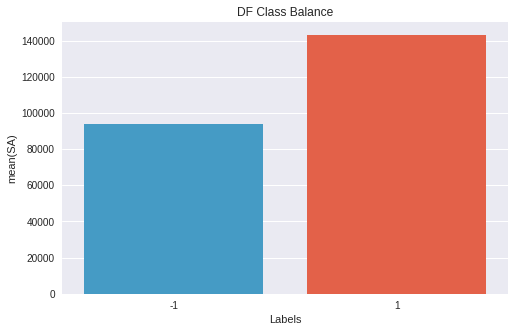

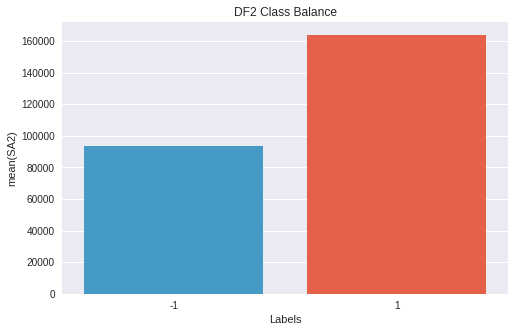

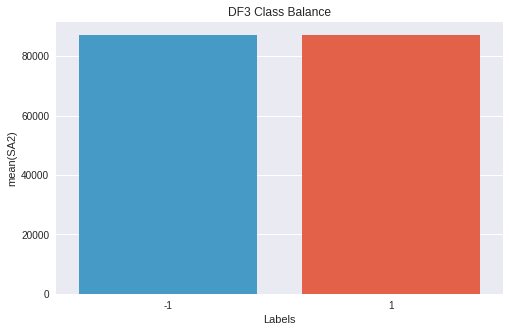

In [12]:
# Removed data to give even batch sizes DF
remove_n = len(df)%50
drop_indices = np.random.choice(df.index, remove_n, replace=False)
df = df.drop(drop_indices)

# Plot the label classes
fig = plt.figure(figsize=(8,5))
ax = sns.barplot(x=df.SA.unique(),y=df.SA.value_counts());
ax.set(xlabel='Labels')
ax.set_title('DF Class Balance')

# Removed data to give even batch sizes DF2
remove_n = len(df2)%50
drop_indices2 = np.random.choice(df2.index, remove_n, replace=False)
df2 = df2.drop(drop_indices2)

# Plot the label classes
fig = plt.figure(figsize=(8,5))
ax = sns.barplot(x=df2.SA2.unique(),y=df2.SA2.value_counts());
ax.set(xlabel='Labels')
ax.set_title('DF2 Class Balance')
plt.savefig('Imbalanced.png')
#files.download('Imbalanced.png')

#Define DF Copy to Reduce and set len
#for each class equal to len og minority class
df3 = pd.concat(g.sample(87155) for idx, g in df2.groupby('SA2'))
df3 = df3.sample(frac=1)

# Removed data to give even batch sizes DF3
remove_n = len(df3)%50
drop_indices3 = np.random.choice(df3.index, remove_n, replace=False)
df3 = df3.drop(drop_indices3)

# Plot the label classes
fig = plt.figure(figsize=(8,5))
ax = sns.barplot(x=df3.SA2.unique(),y=df3.SA2.value_counts());
ax.set(xlabel='Labels')
ax.set_title('DF3 Class Balance')

plt.savefig('Balanced.png')
#files.download('Balancing.png')
plt.show()

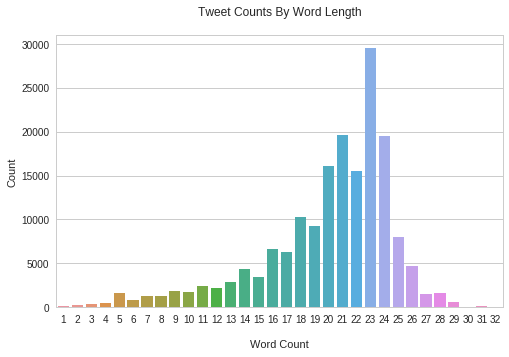

In [13]:
# Exploring tweet word count
z = df3.groupby(by=['word_count'], as_index=False).count(
).sort_values(by='SA2', ascending=False)

plt.figure(figsize=(8, 5))
sns.set_style("whitegrid")
ax = sns.barplot(x=z['word_count'], y=z['SA2'], data=z)
plt.xlabel("\nWord Count")
plt.ylabel("Count")
plt.title("Tweet Counts By Word Length\n")
plt.savefig("Counts By Word Length.png", dpi=300)
#files.download("Counts By Word Length.png")
plt.show()

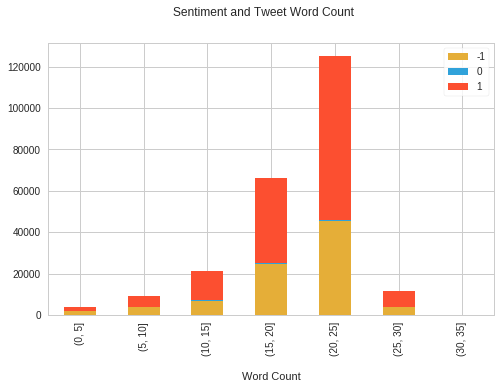

In [14]:
# Exploring Word Count.
colors = color={-1: "#e5ae38",
                0: '#30a2da',
                1: '#fc4f30'}
f, ax = plt.subplots(figsize=(8, 5))
df.groupby(['SA2', pd.cut(df['word_count'], np.arange(0, 40, 5))])\
    .size()\
    .unstack(0)\
    .plot.bar(stacked=True, ax=ax, color=colors.values())
#plt.subplots_adjust(top=.8)
plt.suptitle('Sentiment and Tweet Word Count')
plt.xlabel("\nWord Count")
ax.legend(loc='best', frameon=True)
#plt.savefig("Sentiment and Word Count.png")
#files.download("Sentiment and Word Count.png")
#plt.tight_layout()
plt.show()

We can see similar distribution of word counts, regardless of sentiment. The size difference of the  bars is likely due to the class imbalance we've observed. This could be verified by running the same plot on the trimmed data (DF3).

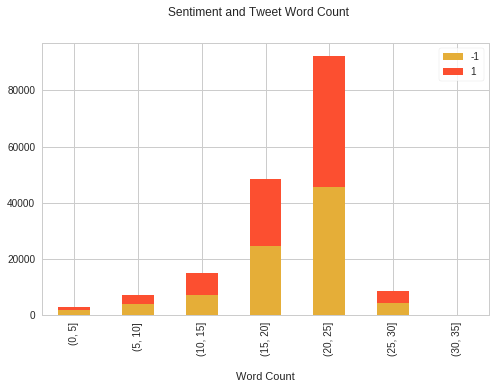

In [15]:
# Exploring Word Count.
colors = color={-1: "#e5ae38",
                1: '#fc4f30'}
f, ax = plt.subplots(figsize=(8, 5))
df3.groupby(['SA2', pd.cut(df3['word_count'], np.arange(0, 40, 5))])\
    .size()\
    .unstack(0)\
    .plot.bar(stacked=True, ax=ax, color=colors.values())
#plt.subplots_adjust(top=.8)
plt.suptitle('Sentiment and Tweet Word Count')
plt.xlabel("\nWord Count")
ax.legend(loc='best', frameon=True)
plt.savefig("Sentiment and Word Count.png", dpi=300)
#files.download("Sentiment and Word Count.png")
#plt.tight_layout()
plt.show()

Voilà! 

# **Unsupervised EDA**


## **TF-IDF**
First, I'll vectorize the text and perform Latent semantic analysis (LSA); a technique in natural language processing of analyzing relationships between a set of documents and the terms they contain by producing a set of concepts related to the documents and terms. We’ll feed this into K-Means and see if we get some clearly defined clusters. 

In [58]:
# convert column of sentiment to list of ints
all_sent = df3.SA2.astype(int).values.tolist()

# 1=positive, 0=negative label conversion
#sent_split = sent_split('\n')
encoded_labels = np.array(
    [1 if sent == 1 else 0 for sent in all_sent])


encoded_labels[:10]

array([1, 1, 1, 1, 0, 0, 0, 0, 1, 0])

In [59]:
X = df3.loc[:, 'clean']
y = encoded_labels
X_train, X_test, Y_train, Y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)

t0 = time()
vectorizer = TfidfVectorizer(max_df=0.5,
                             min_df=2, stop_words='english')

X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.fit_transform(X_test)
print("done in %fs" % (time() - t0))
print("n_samples: %d, n_features: %d" % X_train_tfidf.shape)
print()

done in 2.607927s
n_samples: 130725, n_features: 15415



In [60]:
print("Performing dimensionality reduction using LSA")
t0 = time()

svd = TruncatedSVD(600)
#normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd)#, normalizer)

X_train_lsa = lsa.fit_transform(X_train_tfidf)
X_test_lsa = lsa.fit_transform(X_test_tfidf)

print("done in %fs" % (time() - t0))

explained_variance = svd.explained_variance_ratio_.sum()
print("Explained variance of the SVD step: {}%".format(
    int(explained_variance * 100)))

print()

Performing dimensionality reduction using LSA
done in 84.476938s
Explained variance of the SVD step: 71%



## **K-Means Clustering**

In [61]:
# Since our target is boolean, we expect 2 clusters.
km = KMeans(n_clusters=2, max_iter=100,
            random_state=42)

print("Clustering sparse data with %s" % km)
t0 = time()
km.fit(X_train_lsa)
print("done in %0.3fs" % (time() - t0))
print()

Clustering sparse data with KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
    n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)
done in 19.015s



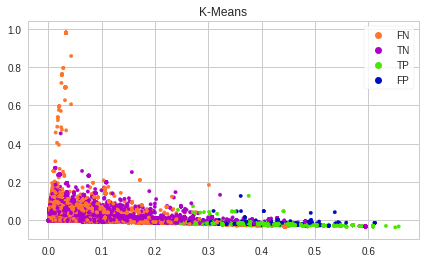


Confusion Matrix:  
 Predicted       0     1     All
True                           
0           64375   947   65322
1           59469  5934   65403
All        123844  6881  130725

                    Classification Report 
               precision    recall  f1-score   support

           0       0.52      0.99      0.68     65322
           1       0.86      0.09      0.16     65403

   micro avg       0.54      0.54      0.54    130725
   macro avg       0.69      0.54      0.42    130725
weighted avg       0.69      0.54      0.42    130725



In [63]:
plt.figure(figsize=(7, 4))
# Calculate predicted values.
y_pred = km.fit_predict(X_train_lsa)

# Calculate Error Type
y_error = (y_pred*2)-Y_train

#Define Error Colors
LABEL_COLOR_MAP = {-1: '#FF752E',
                   0:  '#ad00c8',
                   1: '#4ae500', 
                   2: '#000dbf'
                   }
label_color = [LABEL_COLOR_MAP[i] for i in y_error]
label_convert = {-1: 'FN',
                 0: 'TN',
                 1:'TP',
                 2: 'FP'
                 } 
# Plot the solution.
plt.scatter(X_train_lsa[:, 0], X_train_lsa[:, 1],
            marker='.', c=label_color) 
#Plot the error legend
markers = [
    plt.Line2D([0, 0], [0, 0], color=color,
               marker='o', linestyle=''
               ) for color in LABEL_COLOR_MAP.values()]
plt.legend(markers, label_convert.values(), numpoints=1, frameon=True)
plt.rcParams.update({'font.size': 12})
plt.title('K-Means')
plt.savefig("K-Means.png", dpi =300)
files.download("K-Means.png")
plt.show()

# Check the solution against the data.
cm = pd.crosstab(Y_train, y_pred, rownames=['True'], 
                 colnames=['Predicted'], margins=True)
print("\nConfusion Matrix:  \n", cm)
print("\n                    Classification Report \n",
      classification_report(Y_train, y_pred))

We see some clustering of our positives and negatives (including the mislabeled data points), but I don’t think this is clear enough to be useful. The classification report also indicates a high rate of error. 

## **Word2Vec**
The next unsupervised approach we will investigate is the use of the Word2Vec family of algorithms. Word2vec is a two-layer neural network that processes text.

In [0]:
from string import punctuation

# convert column of tweets to list of words
all_text = df3.clean.astype(str).values.tolist()
string_text = '\n'.join([word for word in all_text])
tweet_split = string_text.split('\n')
string_text = ' '.join(tweet_split)

# create a list of words
words = string_text.split()

In [65]:
len(words)

2566679

In [0]:
all_text2 = df3.filtered_tweet.astype(str).values.tolist()

# store as list of lists of words
sentences = []
for sent_str in all_text:
    tokens = re.sub(r"[^a-z0-9]+", " ", sent_str.lower()).split()
    sentences.append(tokens)
    
# store as list of lists of words
sentences2 = []
for sent_str in all_text2:
    tokens2 = re.sub(r"[^a-z0-9]+", " ", sent_str.lower()).split()
    sentences2.append(tokens2)

Through several iterations I found that Word2Vec performs better without stop words. 

The algorithm takes in data in the shape of a list or lists, where the inner list is comprised of the tokens for a given tweet. The outer list is a list of all the tweets broken down in that fashion.

**Examples below:**


In [67]:
print(sentences[0:2])
print(sentences2[0:2])


[['more', 'baker', 'transcripts', 'not', 'leaked', 'the', 'nyt', 'this', 'time', 'they', 'can', 'spin', 'epoch', 'has', 'got', 'them'], ['incredible', 'see', 'the', 'media', 'coverup', 'marchforlife', 'when', 'handful', 'leftist', 'protest', 'anything', 'especially', 'trump']]
[['baker', 'transcripts', 'leaked', 'nyt', 'time', 'spin', 'epoch', 'got'], ['incredible', 'media', 'coverup', 'marchforlife', 'handful', 'leftist', 'protest', 'especially', 'trump']]


In [0]:
# Instatntiate the model
from gensim.models import Word2Vec

model = Word2Vec(min_count=1)
# Build Vocab
model.build_vocab(sentences2)
# Train the model
#model.train(sentences2, total_examples=model.corpus_count, compute_loss=True,
 #           epochs=model.iter)

In [71]:
#We can iteratively train the model
%%time
w2v_train_loss = []

for epoch in range(50):
  model.train([x for x in tqdm(sentences2)], total_examples=model.corpus_count, 
              compute_loss=True, epochs=1)
  
  w2v_train_loss.append(model.get_latest_training_loss())

100%|██████████| 174300/174300 [00:00<00:00, 2189486.00it/s]


CPU times: user 3min 41s, sys: 1.19 s, total: 3min 42s
Wall time: 1min 57s


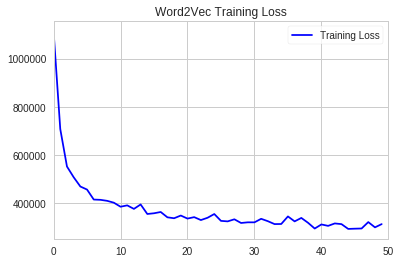

In [72]:
fig=plt.figure()
fig.show()
ax=fig.add_subplot(111)
ax.plot(w2v_train_loss, c='b', label='Training Loss')
plt.xlim(0,50)

plt.legend(loc='upper right', frameon=True)
plt.title('Word2Vec Training Loss')
plt.savefig('trainvalloss.png', dpi=300)
#files.download('trainvalloss.png')
plt.show()

In [73]:
model.wv.most_similar('good', topn=5)

[('great', 0.4566856324672699),
 ('best', 0.41801688075065613),
 ('frac', 0.39857640862464905),
 ('bad', 0.3981844186782837),
 ('terrible', 0.3784672021865845)]

In [74]:
model.similarity('bad', 'good')

0.39818445

In [75]:
len(model.wv.vocab)

33317

The results of the Word2Vec model are not as good as we’d like, as such we will not use this to build a classifier. There may be limitations in play that are specific to the corpus. Through several experiments I have found that the model is sensitive to hyperparameter changes. We’ll try as couple of variations on Word2Vec to see if performance can be improved.  

## **Fast Text**
FastText is an extension to Word2Vec proposed by Facebook in 2016. 

Instead of feeding individual words into the Neural Network, FastText breaks words into several n-grams (sub-words).

In [0]:
from gensim.models import FastText
fast_model = FastText(
    sentences2, size=300, window=4, min_count=2, workers=4,sg=0)

In [77]:
fast_model.wv.most_similar("bad")

[('bada', 0.9032613635063171),
 ('badass', 0.7159971594810486),
 ('ipad', 0.7051912546157837),
 ('badluck', 0.7041375637054443),
 ('bai', 0.6797642707824707),
 ('vlad', 0.6648203134536743),
 ('bac', 0.6367800235748291),
 ('usad', 0.6108507513999939),
 ('load', 0.6073914766311646),
 ('bat', 0.5995541214942932)]

A quick model using some default settings does not indicate it would be much better than the previous model, so we’ll move on.

## **Doc2Vec**
Doc2Vec is a small extension to the CBOW Word2Vec model. 

Instead of using just words to predict the next word, we also add another feature vector, which is document-unique. Each tweet is considered a separate  document.

In [78]:
df4 = df3[['clean', 'SA2']].copy()

df4.head()

,clean,SA2
220359,more baker transcripts not leaked the nyt th...,1
55919,incredible see the media coverup marchforlif...,1
351974,democrats travel minus resort seaside lakes...,1
77360,unprecedented move special counsel office d...,1
304003,active duty members the coast guard are worki...,-1


Doc2Vec takes in “TaggedDocuments” rather than a list of lists. Essentially these are a list of tokens that are paired with a tag, in our case the SA2 label.

In [79]:
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
import multiprocessing
from sklearn import utils
nltk.download('punkt')

train, test = train_test_split(df4, test_size=0.3, random_state=42)

def tokenize_text(text):
    tokens = []
    for sent in sent_tokenize(text):
        for word in word_tokenize(sent):
            if len(word) < 2:
                continue
            tokens.append(word.lower())
    return tokens
train_tagged = train.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['clean']), tags=[r.SA2]), 
    axis=1)

test_tagged = test.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['clean']), tags=[r.SA2]), 
    axis=1)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [80]:
train_tagged.values[30]

TaggedDocument(words=['not', 'even', 'gone', 'hold', 'you', 'fucking', 'hate', 'trump', 'omm'], tags=[-1])

In [81]:
# Instantiate the model and build vocab
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=-1)
model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])

100%|██████████| 122010/122010 [00:00<00:00, 2123246.65it/s]


In [82]:
# Train the model
%%time
for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), 
                     total_examples=len(train_tagged.values), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|██████████| 122010/122010 [00:00<00:00, 1112786.26it/s]


CPU times: user 7.09 s, sys: 102 ms, total: 7.2 s
Wall time: 7.25 s


In [0]:
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

In [0]:
# Defining ML variables
y_train, X_train = vec_for_learning(model_dbow, train_tagged)

y_test, X_test = vec_for_learning(model_dbow, test_tagged)


In [0]:
# Defining a function to fit and predict ML algorithms
def auto_model(mod, model_name, X_train, X_test, y_train, y_test):
    t0 = time()
    mod.fit(X_train, y_train)
    print(model_name)
    print("done in %0.3fs" % (time() - t0))
    y_pred = mod.predict(X_test)
    print('Testing accuracy {:0.2f}' .format(accuracy_score(y_test, y_pred)))
    print('Testing F1 score: {:0.2f}'.format(
    f1_score(y_test, y_pred, average='weighted')))

## **Doc2Vec Classification Models**

In [89]:
# Random Forest Classifier
rfc = RandomForestClassifier(n_estimators=100, n_jobs=-1)
auto_model(rfc, "Random Forest Classifier",
            X_train, X_test, y_train, y_test)

Random Forest Classifier
done in 162.025s
Testing accuracy 0.89
Testing F1 score: 0.89


In [90]:
# Gaussian Naive Bayes
gnb = GaussianNB()
auto_model(gnb, "Gaussian Naive Bayes", 
              X_train, X_test, y_train, y_test)

Gaussian Naive Bayes
done in 0.554s
Testing accuracy 0.67
Testing F1 score: 0.67


In [91]:
# Logistic Regression
log = LogisticRegression(solver='lbfgs')
auto_model(log, "Logistic Regression", X_train, X_test, y_train, y_test)

Logistic Regression
done in 2.736s
Testing accuracy 0.67
Testing F1 score: 0.67


In [92]:
# Linear SVC
svc = LinearSVC()
auto_model(svc, "Linear SVC", X_train, X_test, y_train, y_test)

Linear SVC
done in 10.575s
Testing accuracy 0.69
Testing F1 score: 0.69


The Random Forest Classifier achieved the best performance, although it is far from what we want. As the focus of the project is to develop a Neural Network I won't investigate improving this models performance. 

# **Preparing Data for Pytorch**

In [0]:
from collections import Counter


## Build a dictionary that maps words to integers
counts = Counter(words)
vocab = sorted(counts, key=counts.get, reverse=True)
vocab_to_int = {word: ii for ii, word in enumerate(vocab, 1)}
  
## use the dict to tokenize each tweet in tweet_split
## store the tokenized tweet in tweet_ints
tweet_ints = []
for tweet in tweet_split:
    tweet_ints.append([vocab_to_int[word] for word in tweet.split()])

In [94]:
#vocab_to_int.keys()
print(tweet_split[0])
print(tweet_ints[0])

more baker transcripts not leaked  the nyt  this time  they can spin  epoch has got them
[42, 340, 387, 9, 255, 1, 740, 6, 37, 15, 39, 913, 1034, 29, 118, 169]


In [95]:

# stats about vocabulary
print('Unique words: ', len((vocab_to_int)))  
print()

Unique words:  33585



In [96]:
# outlier tweet stats
tweet_lens = Counter([len(x) for x in tweet_ints])
print("Zero-length tweets: {}".format(tweet_lens[0]))
print("Minimum tweet word count: {}".format(min(tweet_lens)))
print("Maximum tweet word count: {}".format(max(tweet_lens)))

Zero-length tweets: 0
Minimum tweet word count: 1
Maximum tweet word count: 24


In [0]:
def pad_features(tweet_ints, seq_length):
    ''' Return features of tweet_ints, where each tweet is padded with 0's 
        or truncated to the input seq_length.
    '''
    
    # getting the correct rows x cols shape
    features = np.zeros((len(tweet_ints), seq_length), dtype=int)

    # for each review, I grab that review and 
    for i, row in enumerate(tweet_ints):
        features[i, -len(row):] = np.array(row)[:seq_length]
    
    return features

In [0]:
# Test your implementation!

seq_length = 26

features = pad_features(tweet_ints, seq_length=seq_length)

## test statements - do not change - ##
assert len(features)==len(tweet_ints), "Your features should have as many rows as reviews."
assert len(features[0])==seq_length, "Each feature row should contain seq_length values."


In [99]:

split_frac = 0.8

## split data into training, validation, and test data (features and labels, x and y)

split_idx = int(len(features)*split_frac)
train_x, remaining_x = features[:split_idx], features[split_idx:]
train_y, remaining_y = encoded_labels[:split_idx], encoded_labels[split_idx:]

test_idx = int(len(remaining_x)*0.5)
val_x, test_x = remaining_x[:test_idx], remaining_x[test_idx:]
val_y, test_y = remaining_y[:test_idx], remaining_y[test_idx:]

## print out the shapes of your resultant feature data
print("\t\t\tFeature Shapes:")
print("Train set: \t\t{}".format(train_x.shape), 
      "\nValidation set: \t{}".format(val_x.shape),
      "\nTest set: \t\t{}".format(test_x.shape))

			Feature Shapes:
Train set: 		(139440, 26) 
Validation set: 	(17430, 26) 
Test set: 		(17430, 26)


## **DataLoaders and Batching**
After creating training, test, and validation data, we can create DataLoaders for this data by following two steps:

1.   Create a known format for accessing our data, using TensorDataset which takes in an input set of data and a target set of data with the same first dimension, and creates a dataset.
2.   Create DataLoaders and batch our training, validation, and test Tensor datasets


train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))

train_loader = DataLoader(train_data, batch_size=batch_size)

This is an alternative to creating a generator function for batching our data into full batches.

In [0]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
valid_data = TensorDataset(torch.from_numpy(val_x), torch.from_numpy(val_y))
test_data = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))

# dataloaders
batch_size = 30

train_loader = DataLoader(train_data, shuffle=False, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=False, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size)

In [101]:
# obtain one batch of training data
dataiter = iter(train_loader)
sample_x, sample_y = dataiter.next()

print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print()
print('Sample label size: ', sample_y.size()) # batch_size
print('Sample label: \n', sample_y)

Sample input size:  torch.Size([30, 26])
Sample input: 
 tensor([[    0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            42,   340,   387,     9,   255,     1,   740,     6,    37,    15,
            39,   913,  1034,    29,   118,   169],
        [    0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,   567,   209,     1,    31,  1129,   924,    40,
          1137,   641,  1070,   180,   687,     2],
        [    0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,   142,   626,  3758,  2684,  3956,  3957,    51,
          2300,  3811,  2548,  1190,  1228,  3958],
        [    0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,   445,   282,    21,    26,    18,   146,
            10,    20,   184,     2,   120,    16],
        [    0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,  

# Sentiment Network with PyTorch

LSTM Neural Networks, which stand for Long Short-Term Memory, are a particular type of recurrent neural networks. LSTM networks manage to keep contextual information of inputs by integrating a loop that allows information to flow from one step to the next. 

Since tweets are  composed from a sequence of words, and the specific order of those words provide context to the sentiment of the tweet, it stands to reason this Neural Network should predict tweet sentiment well. 

<img src="https://github.com/udacity/deep-learning-v2-pytorch/blob/master/sentiment-rnn/assets/network_diagram.png?raw=1" width=40%>

The layers are as follows:
1. An [embedding layer](https://pytorch.org/docs/stable/nn.html#embedding) that converts our word tokens (integers) into embeddings of a specific size.
2. An [LSTM layer](https://pytorch.org/docs/stable/nn.html#lstm) defined by a hidden_state size and number of layers
3. A fully-connected output layer that maps the LSTM layer outputs to a desired output_size
4. A sigmoid activation layer which turns all outputs into a value 0-1; return **only the last sigmoid output** as the output of this network.

### The Embedding Layer

We need to add an [embedding layer](https://pytorch.org/docs/stable/nn.html#embedding) because there are tens of thousands of words in our vocabulary. It is massively inefficient to one-hot encode that many classes. So, instead of one-hot encoding, we can have an embedding layer and use that layer as a lookup table.** I could train an embedding layer using Word2Vec, then load it here. But, it's recommended to just make a new layer, using it for only dimensionality reduction, and let the network learn the weights.**


### The LSTM Layer(s)

We'll create an [LSTM](https://pytorch.org/docs/stable/nn.html#lstm) to use in our recurrent network, which takes in an input_size, a hidden_dim, a number of layers, a dropout probability (for dropout between multiple layers), and a batch_first parameter.





In [102]:
# First checking if GPU is available
train_on_gpu=torch.cuda.is_available()

if(train_on_gpu):
    print('Training on GPU.')
else:
    print('No GPU available, training on CPU.')

Training on GPU.


In [0]:

import torch.nn as nn

class SentimentRNN(nn.Module):
    """
    The RNN model that will be used to perform Sentiment analysis.
    """

    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):
        """
        Initialize the model by setting up the layers.
        """
        super(SentimentRNN, self).__init__()

        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        # embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, 
                            dropout=drop_prob, batch_first=True)
        
        # dropout layer
        self.dropout = nn.Dropout(0.3)
        
        # linear and sigmoid layers
        self.fc = nn.Linear(hidden_dim, output_size)
        self.sig = nn.Sigmoid()
        

    def forward(self, x, hidden):
        """
        Perform a forward pass of our model on some input and hidden state.
        """
        batch_size = x.size(0)

        # embeddings and lstm_out
        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)
    
        # stack up lstm outputs
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        
        # dropout and fully-connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)
        # sigmoid function
        sig_out = self.sig(out)
        
        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)
        sig_out = sig_out[:, -1] # get last batch of labels
        
        # return last sigmoid output and hidden state
        return sig_out, hidden
    
    
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        
        if (train_on_gpu):
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim
                                ).zero_().cuda(),
                  weight.new(self.n_layers, batch_size, self.hidden_dim
                            ).zero_().cuda())
        else:
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim
                                ).zero_(),
                      weight.new(self.n_layers, batch_size, self.hidden_dim
                                ).zero_())
        
        return hidden

## Instantiate the network

Here, we'll instantiate the network. First up, defining the hyperparameters.

* `vocab_size`: Size of our vocabulary or the range of values for our input, word tokens.
* `output_size`: Size of our desired output; the number of class scores we want to output (pos/neg).
* `embedding_dim`: Number of columns in the embedding lookup table; size of our embeddings.
* `hidden_dim`: Number of units in the hidden layers of our LSTM cells. Usually larger is better performance wise. Common values are 128, 256, 512, etc.
* `n_layers`: Number of LSTM layers in the network. Typically between 1-3

In [104]:
len(vocab_to_int)

33585

In [105]:
# Instantiate the model w/ hyperparams
vocab_size = len(vocab_to_int)+1 # +1 for the 0 padding + our word tokens
output_size = 1
embedding_dim = 300
hidden_dim = 256
n_layers = 2

net = SentimentRNN(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)

print(net)

SentimentRNN(
  (embedding): Embedding(33586, 300)
  (lstm): LSTM(300, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.3)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)


## Training
​
Below is the typical training code. 
​
>We'll also be using a new kind of cross entropy loss, which is designed to work with a single Sigmoid output. [BCELoss](https://pytorch.org/docs/stable/nn.html#bceloss), or **Binary Cross Entropy Loss**, applies cross entropy loss to a single value between 0 and 1.
​
We also have some data and training hyparameters:
​
* `lr`: Learning rate for our optimizer.
* `epochs`: Number of times to iterate through the training dataset.
* `clip`: The maximum gradient value to clip at (to prevent exploding gradients).

In [0]:
# loss and optimization functions
lr=0.001

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

In [107]:

# training params

epochs = 1 # 3-4 is approx where I noticed the validation loss stop decreasing

counter = 0
print_every = 100
clip=5 # gradient clipping

train_loss = []
val_loss1 = []

# move model to GPU, if available
if(train_on_gpu):
    net.cuda()

net.train()
# train for some number of epochs
for e in range(epochs):
    # initialize hidden state
    h = net.init_hidden(batch_size)

    # batch loop
    for inputs, labels in train_loader:
        counter += 1

        if(train_on_gpu):
            inputs, labels = inputs.cuda(), labels.cuda()

        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])

        # zero accumulated gradients
        net.zero_grad()

        # get the output from the model
        output, h = net(inputs, h)

        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(net.parameters(), clip)
        optimizer.step()

        # loss stats
        if counter % print_every == 0:
            # Get validation loss
            val_h = net.init_hidden(batch_size)
            val_losses = []
            net.eval()
            for inputs, labels in valid_loader:

                # Creating new variables for the hidden state, otherwise
                # we'd backprop through the entire training history
                val_h = tuple([each.data for each in val_h])

                if(train_on_gpu):
                    inputs, labels = inputs.cuda(), labels.cuda()

                output, val_h = net(inputs, val_h)
                val_loss = criterion(output.squeeze(), labels.float())

                val_losses.append(val_loss.item())

            net.train()
          
            print("Epoch: {}/{}...".format(e+1, epochs),
                  "Step: {}...".format(counter),
                  "Loss: {:.6f}...".format(loss.item()),
                  "Val Loss: {:.6f}".format(np.mean(val_losses)))
            train_loss.append(loss.item())
            val_loss1.append(np.mean(val_losses))
           

Epoch: 1/1... Step: 100... Loss: 0.310905... Val Loss: 0.380225
Epoch: 1/1... Step: 200... Loss: 0.148802... Val Loss: 0.298961
Epoch: 1/1... Step: 300... Loss: 0.158908... Val Loss: 0.254336
Epoch: 1/1... Step: 400... Loss: 0.194628... Val Loss: 0.216628
Epoch: 1/1... Step: 500... Loss: 0.202043... Val Loss: 0.200281
Epoch: 1/1... Step: 600... Loss: 0.130571... Val Loss: 0.172984
Epoch: 1/1... Step: 700... Loss: 0.158043... Val Loss: 0.161999
Epoch: 1/1... Step: 800... Loss: 0.211854... Val Loss: 0.164240
Epoch: 1/1... Step: 900... Loss: 0.311433... Val Loss: 0.144542
Epoch: 1/1... Step: 1000... Loss: 0.139544... Val Loss: 0.159287
Epoch: 1/1... Step: 1100... Loss: 0.102803... Val Loss: 0.133186
Epoch: 1/1... Step: 1200... Loss: 0.027556... Val Loss: 0.129935
Epoch: 1/1... Step: 1300... Loss: 0.159299... Val Loss: 0.122718
Epoch: 1/1... Step: 1400... Loss: 0.106025... Val Loss: 0.110826
Epoch: 1/1... Step: 1500... Loss: 0.060349... Val Loss: 0.105119
Epoch: 1/1... Step: 1600... Loss: 

## **Testing the Network**

In [108]:
# Get test data loss and accuracy

test_losses = [] # track loss
num_correct = 0
pred_tens = [] # Track preds

# init hidden state
h = net.init_hidden(batch_size)

net.eval()
# iterate over test data
for inputs, labels in test_loader:

    # Creating new variables for the hidden state, otherwise
    # we'd backprop through the entire training history
    h = tuple([each.data for each in h])

    if(train_on_gpu):
        inputs, labels = inputs.cuda(), labels.cuda()
    
    # get predicted outputs
    output, h = net(inputs, h)
    
    # calculate loss
    test_loss = criterion(output.squeeze(), labels.float())
    test_losses.append(test_loss.item())
    
    # convert output probabilities to predicted class (0 or 1)
    pred = torch.round(output.squeeze())  # rounds to the nearest integer
    pred_tens.append(pred.cpu().detach().numpy())
    
    # compare predictions to true label
    correct_tensor = pred.eq(labels.float().view_as(pred))
    correct = np.squeeze(
        correct_tensor.numpy()) if not train_on_gpu else np.squeeze(
        correct_tensor.cpu().numpy())
    num_correct += np.sum(correct)


# -- stats! -- ##
# avg test loss
print("Test loss: {:.3f}".format(np.mean(test_losses)))

# accuracy over all test data
test_acc = num_correct/len(test_loader.dataset)
print("Test accuracy: {:.3f}".format(test_acc))

#Flatten list of lists containing predictions
flat_list = [item.astype(int) for sublist in pred_tens for item in sublist]

#Convert list to np array
pred_array = np.asarray(flat_list)

# Check the solution against the data.
cm = pd.crosstab(pred_array, test_y, rownames=['True'], 
                 colnames=['Predicted'], margins=True)
print("\nConfusion Matrix:  \n", cm)
print("\n                    Classification Report \n",
      classification_report(flat_list, test_y))

Test loss: 0.050
Test accuracy: 0.983

Confusion Matrix:  
 Predicted     0     1    All
True                        
0          8578   151   8729
1           145  8556   8701
All        8723  8707  17430

                    Classification Report 
               precision    recall  f1-score   support

           0       0.98      0.98      0.98      8729
           1       0.98      0.98      0.98      8701

   micro avg       0.98      0.98      0.98     17430
   macro avg       0.98      0.98      0.98     17430
weighted avg       0.98      0.98      0.98     17430



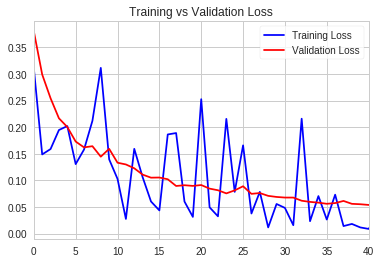

In [109]:
fig=plt.figure()
fig.show()
ax=fig.add_subplot(111)
ax.plot(train_loss, c='b', label='Training Loss')
ax.plot(val_loss1, c='r', label='Validation Loss')
plt.xlim(0,40)

plt.legend(loc='upper right', frameon=True)
plt.title('Training vs Validation Loss')
#plt.savefig('trainvalloss.png', dpi=300)
#files.download('trainvalloss.png')
plt.show()

In [0]:
#torch.save(net.state_dict(), '/content/gdrive/My Drive/Data Science/net.pth')

In [0]:
#PATH = '/content/gdrive/My Drive/Data Science'
#torch.save(
#SentimentRNN, '/content/gdrive/My Drive/Data Science/SentimentRNN.pth')


## Testing Brand New Tweets

In [0]:
from string import punctuation

def tokenize_comment(test_comment):
    
    # Remove URLs
    test_comment = test_comment.replace('https?://[A-Za-z0-9./]+','')
    
    # Keep Hashtag text
    test_comment = test_comment.replace("[^a-zA-Z]", " ")
    
    # Remove whitespace
    #test_comment = test_comment.replace(' ', '')
    
    # Remove 1-2 letter words
    test_comment = test_comment.replace("r'\b\w{1,2}\b", '')
    
    # Remove numbers
    test_comment = test_comment.replace('\d+', '')
    
    # Lowercase
    test_comment = test_comment.lower() # lowercase
    
    # get rid of punctuation
    test_text = ''.join([c for c in test_comment if c not in punctuation])
    
    # Remove Stopwords
    #test_text = ''.join([word for word in test_text.split() if word not in (stop)])
    
    # splitting by spaces
    test_words = [word for word in test_text.split() if word not in (stop)]

    # tokens
    test_ints = []
    test_ints.append([vocab_to_int[word] for word in test_words if word in vocab])

    return test_ints


In [0]:
# test sequence padding
#seq_length=26
#neg_features = pad_features(test_ints_neg, seq_length)
#pos_features = pad_features(test_ints_pos, seq_length)

In [0]:
# test conversion to tensor and pass into your model
#neg_feature_tensor = torch.from_numpy(neg_features)
#pos_feature_tensor = torch.from_numpy(pos_features)

In [0]:
def predict(net, test_comment, sequence_length=43):
    
    net.eval()
    
    # tokenize review
    test_ints = tokenize_comment(test_comment)
    
    # pad tokenized sequence
    seq_length=sequence_length
    features = pad_features(test_ints, seq_length)
    
    # convert to tensor to pass into your model
    feature_tensor = torch.from_numpy(features)
    
    batch_size = feature_tensor.size(0)
    
    # initialize hidden state
    h = net.init_hidden(batch_size)
    
    if(train_on_gpu):
        feature_tensor = feature_tensor.cuda()
    
    # get the output from the model
    output, h = net(feature_tensor, h)
    
    # convert output probabilities to predicted class (0 or 1)
    pred = torch.round(output.squeeze()) 
    # printing output value, before rounding
    print('Prediction value, pre-rounding: {:.6f}'.format(output.item()))
    
    # print custom response
    if(pred.item()==1):
        print("Positive comment detected!")
    else:
        print("Negative comment detected.")

In [0]:
# negative test comment
test_comment_neg = "Ashamed of my country today. This ban in hurtful and completely unnecessary. @realDonaldTrump, for someone so seemingly obsessed with national security, why are you stripping the rights of people who just want to protect us?! #transmilitaryban"
test_comment_neg2 = "This is bad!"
live_test_neg = ""

# positive test comment
test_comment_pos = "Christopher Nolan is the kind of man who is given a release date for a film that has no title, probably just a draft of a script, and no cast. If that’s not POWER than I don’t know what is. #ChristopherNolan #King"
test_comment_pos2 = "This is good."
live_test_pos = ""

In [116]:
# Negative test 1
seq_length=26 # good to use the length that was trained on

predict(net, test_comment_neg, seq_length)

Prediction value, pre-rounding: 0.644565
Positive comment detected!


In [117]:
# Negative test 2
seq_length=26 
predict(net, test_comment_neg2, seq_length)

Prediction value, pre-rounding: 0.000512
Negative comment detected.


In [118]:
# Positive Test 1
seq_length=26 

predict(net, test_comment_pos, seq_length)

Prediction value, pre-rounding: 0.998572
Positive comment detected!


In [119]:
# Positive Test 2
seq_length=26 
predict(net, test_comment_pos2, seq_length)

Prediction value, pre-rounding: 0.999140
Positive comment detected!


In [0]:
if 1==0:
  # Live test 
  seq_length=26 
  print(predict(net, live_test_pos, seq_length))
  print('\n')
  print(predict(net, live_test_neg, seq_length))

# **Conclusion**









1.  The LSTM RNN was better at classifying  tweets as positive or negative as compared to a Random Forest Classifier.
2.  The presence of stop words does not seem to impair the RNN.
3. The RNN does struggle with short and simple negative comments. This could be due to:

    *   The limited vocabulary present in the corpus.
    *   A lack of context.
 

# **Future Work**




*   The next investigative work I plan to do is to feed the RNN an embedding layer trained with Word2Vec or Sense2Vec weights. This could illuminate if the contextual issue is why the test string failed.
* Additionally I will investigate using part of speech tagging to improve the model.
*   I would also like to add more data to my dataset, pulling tweets using filters based on product brands and entertainment. 
* Lastly I would like to develop a multi label classifier that predicts neutral sentiment as well.

